In [1]:
import tensorflow as tf 
from tensorflow import keras
from keras import layers
import os 
import numpy as np 
import matplotlib.pyplot as plt
from glob import glob
import cv2
from scipy import ndimage
import sys 
import random 

from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip

In [2]:
# base_path = 'D:/Dropbox/WORK/SNUH/Atopy Segmentation'
base_path = 'C:/Users/user/Desktop/datasets/Atopy Segmentation'
# path_8 = os.path.join(base_path, 'Intersect_0.8')
paths = ['Intersect_0.75', 'Intersect_0.8', 'Intersect_0.85']
grades = ['Grade0', 'Grade1', 'Grade2', 'Grade3']

# path = paths[2]
# grade = grades[3]
# N_RES = 256
num_batch = 32
num_bef_res = 320
num_res = 256
# num_classes = [0, 1, 2, 3]

classes = [0, 1, 2]
num_classes = len(classes)
grades_dict = {0 : 'Grade0', 1 : 'Grade1', 2 : 'Grade2', 3 : 'Grade3'}

In [3]:
# x_train = {}
# y_train = {}

# x_test = {}
# y_test = {}

# x_extra = {}
# y_extra = {} 


# for path in paths:  
# for grade in grades:
train_list = glob(os.path.join(base_path, paths[2], 'Atopy_Segment_Train', f'*/*.jpg'))
# y_train_list = glob(os.path.join(base_path, paths[2], 'Atopy_Segment_Train', f'*/*.png'))

test_list = glob(os.path.join(base_path, paths[2], 'Atopy_Segment_Test', f'*/*.jpg'))
# y_test_list = glob(os.path.join(base_path, paths[2], 'Atopy_Segment_Test', f'*/*.png'))

extra_list = glob(os.path.join(base_path, paths[2], 'Atopy_Segment_Extra', f'*/*.jpg'))
# y_extra_list = glob(os.path.join(base_path, paths[2], 'Atopy_Segment_Extra', f'*/*.png'))

In [4]:
def create_dataset(data_list, dtype='train'):
    images = [] 
    masks = [] 
    labels = [] 
    
    for x in data_list:
        img = cv2.imread(x, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (num_res, num_res)) / 255.
        
        y = x[:-4] + '.png'
        
        if os.path.isfile(y) == False:
            print(f'Not found mask file : {x}') 
            # none_mask += 1
            continue
        
        msk = cv2.imread(y, 0)
        msk = cv2.resize(msk, (num_res, num_res))
        msk[msk > 0] = 1.
        msk = np.float32(msk)

        lbl = y.split('\\')[-2][-1]
        
        if lbl == '2':
            lbl = '1'
            
        if lbl == '3':
            lbl = '2'
            
        # print(f'{lbl} type is {type(lbl)} and length {len(lbl)}')
            
        
        images.append(img) 
        masks.append(msk) 
        labels.append(tf.keras.utils.to_categorical(lbl, num_classes)) 
        # labels.append(lbl)
        
        if dtype != 'test':
        
            if np.random.randint(2) > 0:
                aug = RandomRotate90(p=1.0)
                augmented = aug(image=img, mask=msk)
                images.append(augmented['image'])
                masks.append(augmented['mask'])
                # labels.append(lbl) 
                labels.append(tf.keras.utils.to_categorical(lbl, num_classes)) 

            if np.random.randint(2) > 0:
                aug = GridDistortion(p=1.0)
                augmented = aug(image=img, mask=msk)
                images.append(augmented['image'])
                masks.append(augmented['mask'])
                # labels.append(lbl) 
                labels.append(tf.keras.utils.to_categorical(lbl, num_classes)) 

            if np.random.randint(2) > 0:
                aug = HorizontalFlip(p=1.0)
                augmented = aug(image=img, mask=msk)
                images.append(augmented['image'])
                masks.append(augmented['mask'])
                # labels.append(lbl) 
                labels.append(tf.keras.utils.to_categorical(lbl, num_classes)) 

            if np.random.randint(2) > 0:
                aug = VerticalFlip(p=1.0)
                augmented = aug(image=img, mask=msk)
                images.append(augmented['image'])
                masks.append(augmented['mask'])
                # labels.append(lbl) 
                labels.append(tf.keras.utils.to_categorical(lbl, num_classes)) 
        
    # 
    images = np.reshape(images, [-1, num_res, num_res, 3])
    masks = np.reshape(masks, [-1, num_res, num_res, 1])
    labels = np.reshape(labels, [-1, num_classes])
    # labels = np.reshape(labels, [-1, 1])
    
    if dtype != 'test':
        idx = np.arange(images.shape[0])
        np.random.shuffle(idx) 
        
        images = images[idx]
        masks = masks[idx]
        labels = labels[idx]
    
    return images, masks, labels

In [5]:
train_images, train_masks, train_labels = create_dataset(train_list)
test_images, test_masks, test_labels = create_dataset(test_list, dtype='test')
extra_images, extra_masks, extra_labels = create_dataset(extra_list, dtype='extra')

train_images.shape, test_images.shape, extra_images.shape

Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.85\Atopy_Segment_Train\Grade2\0391.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.85\Atopy_Segment_Train\Grade2\0807.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.85\Atopy_Segment_Test\Grade1\8171.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.85\Atopy_Segment_Test\Grade2\6990.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.85\Atopy_Segment_Test\Grade2\6995.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.85\Atopy_Segment_Test\Grade2\7331.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.85\Atopy_Segment_Test\Grade2\7338.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.85\Atopy_Segment_Extra\Grade1\9902.jpg


((3157, 256, 256, 3), (630, 256, 256, 3), (2162, 256, 256, 3))

In [6]:
train_images = np.concatenate([train_images, extra_images], axis=0)
train_labels = np.concatenate([train_labels, extra_labels], axis=0)

mixed_list = list(zip(train_images, train_labels))
random.shuffle(mixed_list) # shuffle
train_images, train_labels = zip(*mixed_list)


train_images = np.array(train_images)
train_labels = np.array(train_labels)

train_images.shape, train_labels.shape

((5319, 256, 256, 3), (5319, 3))

c:\ProgramData\Miniconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


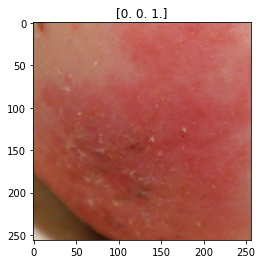

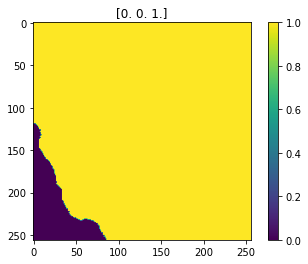

In [7]:
plt.imshow(train_images[1])
plt.title(train_labels[1])
plt.show() 

plt.imshow(train_masks[1])
plt.title(train_labels[1])
plt.colorbar()
plt.show()

In [8]:
def create_mask(pred_mask):
    # pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask = pred_mask[..., tf.newaxis]
    # return pred_mask[0]
    return np.squeeze(pred_mask, axis=0)

# from IPython.display import clear_output

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [9]:
# import sys 
# sys.path.append('../')
# from segmentation_models2 import segmentation_models as sm
# sm.set_framework('tf.keras')
# sm.framework()

# tr = True
# model = sm.Unet('efficientnetb4', encoder_weights='imagenet', activation='sigmoid', input_shape=(num_res, num_res, 3))
# preprocess_input = sm.get_preprocessing('efficientnetb4')


In [10]:
# with open('modelsummary.txt', 'w') as f:
#     model.summary(print_fn=lambda x: f.write(x + '\n'))

In [11]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3
import tensorflow as tf

print("TF Version: ", tf.__version__)

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x


TF Version:  2.8.0


In [12]:

def build_effienet_multi(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained Encoder """
    encoder = EfficientNetB3(include_top=False, weights="imagenet", input_tensor=inputs)

    s1 = encoder.get_layer("input_1").output                      ## 256
    s2 = encoder.get_layer("block2a_expand_activation").output    ## 128
    s3 = encoder.get_layer("block3a_expand_activation").output    ## 64
    s4 = encoder.get_layer("block4a_expand_activation").output    ## 32

    """ Bottleneck """
    b1 = encoder.get_layer("block6a_expand_activation").output    ## 16

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                               ## 32
    d2 = decoder_block(d1, s3, 256)                               ## 64
    d3 = decoder_block(d2, s2, 128)                               ## 128
    d4 = decoder_block(d3, s1, 64)                                ## 256

    """ Output """
    x1 = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    
    # """ Classification """
    # x2 = encoder.output
    x2 = encoder.get_layer("input_1").output
    x2 = tf.keras.layers.GlobalAveragePooling2D()(x2) 
    x2 = tf.keras.layers.Dense(num_classes)(x2) 
    x2 = tf.keras.layers.BatchNormalization()(x2) 
    x2 = tf.keras.layers.Softmax()(x2) 

    # model = Model(inputs, outputs, name="EfficientNetB0_UNET")
    model = Model(inputs, [x1, x2], name="EfficientNetB0_UNET")
    return model

def build_effienet_seg(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained Encoder """
    encoder = EfficientNetB3(include_top=False, weights="imagenet", input_tensor=inputs)

    s1 = encoder.get_layer("input_1").output                      ## 256
    s2 = encoder.get_layer("block2a_expand_activation").output    ## 128
    s3 = encoder.get_layer("block3a_expand_activation").output    ## 64
    s4 = encoder.get_layer("block4a_expand_activation").output    ## 32

    """ Bottleneck """
    b1 = encoder.get_layer("block6a_expand_activation").output    ## 16

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                               ## 32
    d2 = decoder_block(d1, s3, 256)                               ## 64
    d3 = decoder_block(d2, s2, 128)                               ## 128
    d4 = decoder_block(d3, s1, 64)                                ## 256

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    
    # """ Classification """
    # x = encoder.output
    # x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    # x = tf.keras.layers.Dense(4)(x) 
    # x = tf.keras.layers.BatchNormalization()(x) 
    # x = tf.keras.layers.Softmax()(x) 

    model = Model(inputs, outputs, name="EfficientNetB0_UNET")
    # model = Model(inputs, [outputs, x], name="EfficientNetB0_UNET")
    return model

def build_effienet_cls(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained Encoder """
    encoder = EfficientNetB3(include_top=False, weights="imagenet", input_tensor=inputs)

    # s1 = encoder.get_layer("input_1").output                      ## 256
    # s2 = encoder.get_layer("block2a_expand_activation").output    ## 128
    # s3 = encoder.get_layer("block3a_expand_activation").output    ## 64
    # s4 = encoder.get_layer("block4a_expand_activation").output    ## 32

    # """ Bottleneck """
    # b1 = encoder.get_layer("block6a_expand_activation").output    ## 16

    # """ Decoder """
    # d1 = decoder_block(b1, s4, 512)                               ## 32
    # d2 = decoder_block(d1, s3, 256)                               ## 64
    # d3 = decoder_block(d2, s2, 128)                               ## 128
    # d4 = decoder_block(d3, s1, 64)                                ## 256

    # """ Output """
    # outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    
    # """ Classification """
    x = encoder.output
    # x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    # x = tf.keras.layers.Dense(4)(x) 
    # x = tf.keras.layers.BatchNormalization()(x) 
    # x = tf.keras.layers.Softmax()(x) 
    
    x = keras.layers.GlobalAveragePooling2D()(x) 

    x = keras.layers.Dense(512, activation='swish')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    
    x = keras.layers.Dense(256, activation='swish')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)

        
    x = keras.layers.Dense(10, activation='softmax')(x)

    # model = Model(inputs, outputs, name="EfficientNetB0_UNET")
    model = Model(inputs, x, name="EfficientNetB0_UNET")
    # model = Model(inputs, [outputs, x], name="EfficientNetB0_UNET")
    return model

def scratch_model(input_shape):
    inputs = keras.layers.Input(input_shape)
    # x = keras.layers.Conv2D(32, (3, 3), padding='same')(inputs)
    # x = keras.layers.Activation('relu')(x)
    # x = keras.layers.Conv2D(32, (3, 3), padding='same')(x)
    # x = keras.layers.Activation('relu')(x)
    # x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    # x = keras.layers.Dropout(0.5)(x)
    
    # x = keras.layers.Flatten()(x)
    # x = keras.layers.Dense(512)(x)
    # x = keras.layers.Activation('relu')(x)
    # x = keras.layers.Dropout(0.7)(x)
    # x = keras.layers.Dense(4)(x)
    # x = keras.layers.Activation('softmax')(x)
    # x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
        
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    
    return Model(inputs, outputs)


In [13]:
# if __name__ == "__main__":
input_shape = (num_res, num_res, 3)
model = build_effienet_cls(input_shape)
# model = build_effienet_seg(input_shape)
# model = build_effienet_multi(input_shape)
# model = scratch_model(input_shape)
# model.summary()

In [14]:
def dice_score_loss(y_true, y_pred):
    numerator = 2. * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return tf.reduce_mean(1 - numerator / denominator)

In [15]:
import math

class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, max_lr, warmup_steps, decay_steps):
        super(CustomSchedule, self).__init__()
        self.max_lr = max_lr
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps

    def __call__(self, step):
        lr = tf.cond(step < self.warmup_steps, 
                        lambda: self.max_lr / self.warmup_steps * step, 
                        lambda: 0.5 * (1+tf.math.cos(math.pi * (step - self.warmup_steps) / self.decay_steps))*self.max_lr)
        return lr

In [16]:
LR = 0.001
# n_classes = 4


# define optomizer
# optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

# metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', mode='auto', factor=0.2, patience=5, min_lr=0.0001)

steps_per_epoch = len(train_images) // num_batch
lr_schedule = CustomSchedule(LR, 3*steps_per_epoch, 50*steps_per_epoch)

# def loss_fn(y_true, y_pred):
#     cls_labels = tf.cast(y_true[:,:1], tf.int64)
#     loc_labels = y_true[:,1:]
#     cls_preds = y_pred[:,:2]
#     loc_preds = y_pred[:,2:]
#     loc_loss = keras.losses.MeanSquaredError()(loc_labels, loc_preds)
#     cls_loss = keras.losses.SparseCategoricalCrossentropy()(cls_labels, cls_preds)
#     return cls_loss + 5*loc_loss

# ''' Multi '''
# model.compile(
#     # optimizer=[keras.optimizers.Adam(0.001), 
#     #            keras.optimizers.Adam(0.001)],
#     optimizer=keras.optimizers.Adam(0.001),
#     # loss=[keras.losses.MeanSquaredError(),
#     #       keras.losses.SparseCategoricalCrossentropy()],
#     # loss=[dice_score_loss,
#     #       keras.losses.SparseCategoricalCrossentropy()],
#     metrics=['accuracy'],
# )

''' Segmentation '''
# model.compile(
#     keras.optimizers.Adam(0.001), 
#     loss=dice_score_loss,
#     metrics=['accuracy'],
# )

# ''' Classification '''
model.compile(
    # keras.optimizers.Adam(lr_schedule), 
    keras.optimizers.SGD(learning_rate=0.001), 
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy'],
)

In [20]:
(x_tr, y_tr), (x_te, y_te) = tf.keras.datasets.mnist.load_data() 

x_tr = x_tr / 255. 
y_tr = tf.keras.utils.to_categorical(y_tr, 10)

In [21]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')

# hist = model.fit(train_images,
#                 #  train_masks,
#                 train_labels,
#                 # [train_masks, train_labels],
#                  batch_size=num_batch,
#                  epochs=200,
#                  validation_split=0.001,
#                 # validation_data=(extra_images, [extra_masks, extra_labels]),
#                 # validation_data=(extra_images, extra_labels),
#                 # validation_data=(extra_images, extra_masks),
#                 # validation_data=valid_ds,
#                  shuffle=True,
#                  callbacks=[early]
#                  )
hist = model.fit(x_tr,
                #  train_masks,
                y_tr,
                # [train_masks, train_labels],
                 batch_size=num_batch,
                 epochs=200,
                 validation_split=0.001,
                # validation_data=(extra_images, [extra_masks, extra_labels]),
                # validation_data=(extra_images, extra_labels),
                # validation_data=(extra_images, extra_masks),
                # validation_data=valid_ds,
                 shuffle=True,
                 callbacks=[early]
                 )

Epoch 1/200


ValueError: in user code:

    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "EfficientNetB0_UNET" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(None, 28, 28)


In [18]:
model.evaluate(test_images, test_labels)

20/20 [==============================] - 2s 70ms/step - loss: 67.5144 - accuracy: 0.6921


[67.514404296875, 0.6920635104179382]

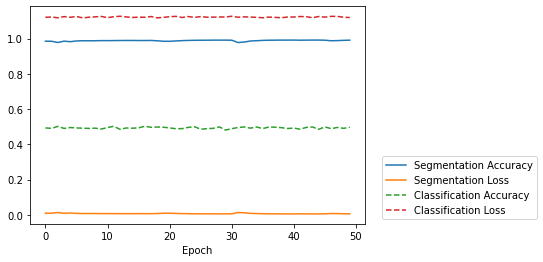

In [37]:
plt.plot(hist.history['conv2d_8_accuracy'], label='Segmentation Accuracy')
plt.plot(hist.history['conv2d_8_loss'], label='Segmentation Loss')
plt.plot(hist.history['softmax_accuracy'], '--', label='Classification Accuracy')
plt.plot(hist.history['softmax_loss'], '--', label='Classification Loss')
plt.legend(loc=(1.05, 0.02))
plt.xlabel('Epoch')
plt.show() 
# plt.plot(hist.history['accuracy'])

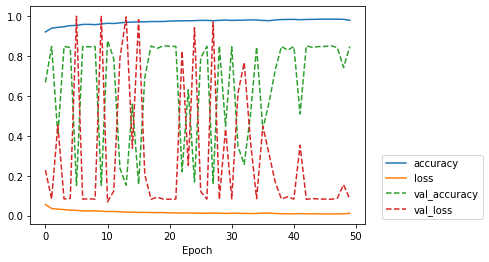

In [17]:
# for cls or seg
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], '--', label='val_accuracy')
plt.plot(hist.history['val_loss'], '--', label='val_loss')
plt.legend(loc=(1.05, 0.02))
plt.xlabel('Epoch')
plt.show() 

In [18]:
model.evaluate(test_images, test_masks, batch_size=16)

40/40 [==============================] - 4s 79ms/step - loss: 0.0627 - accuracy: 0.8826


[0.062705859541893, 0.8826225399971008]

In [17]:
model.evaluate(test_images, test_labels, batch_size=16)

40/40 [==============================] - 3s 44ms/step - loss: 3.4978 - accuracy: 0.0714


[3.4978487491607666, 0.0714285746216774]

In [17]:
test_masks.shape, test_labels.shape

((630, 256, 256, 1), (630, 1))

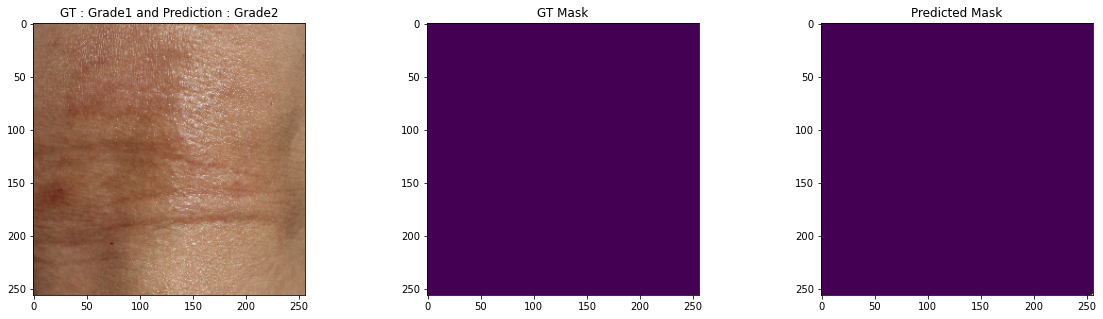

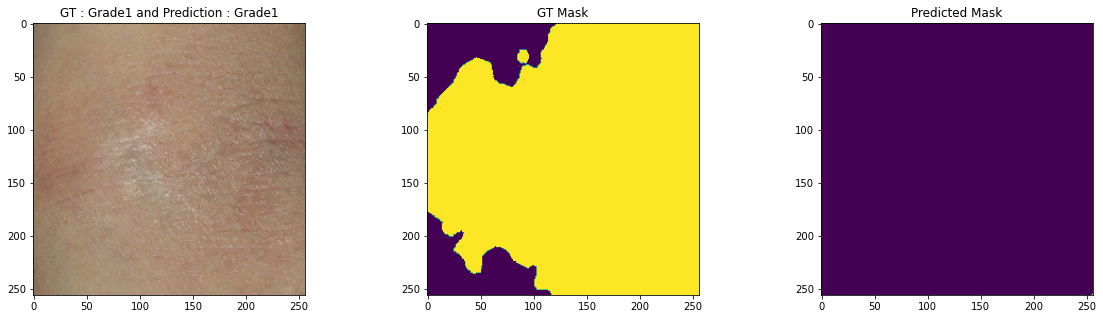

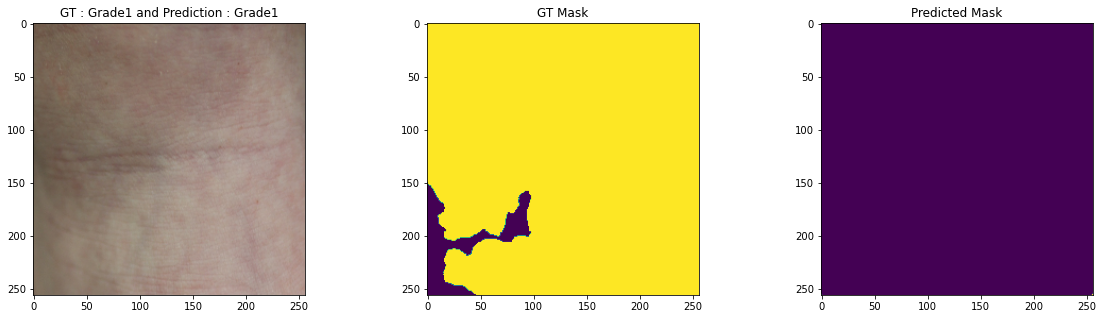

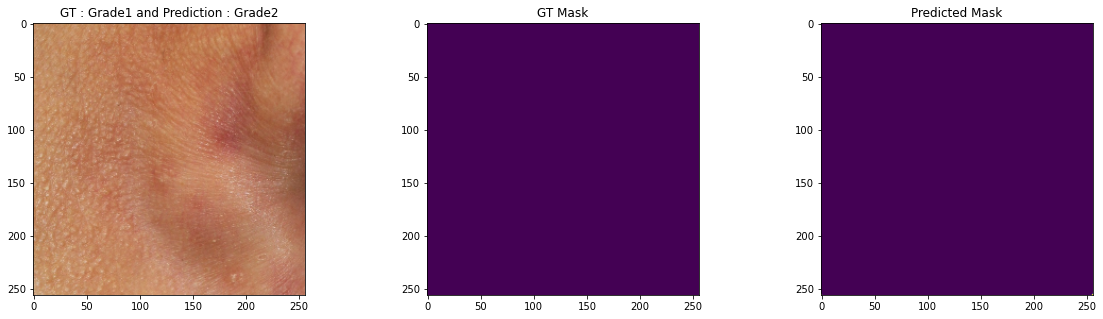

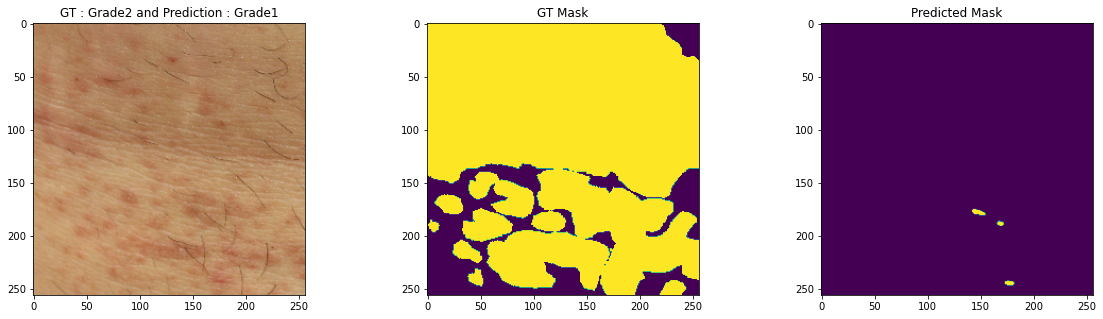

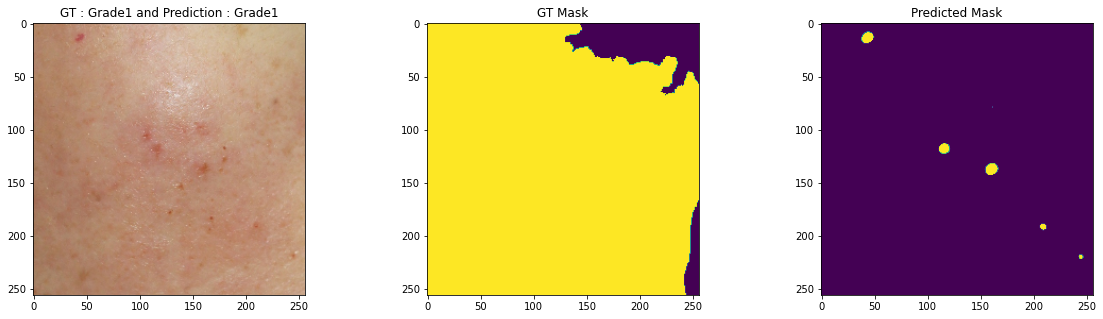

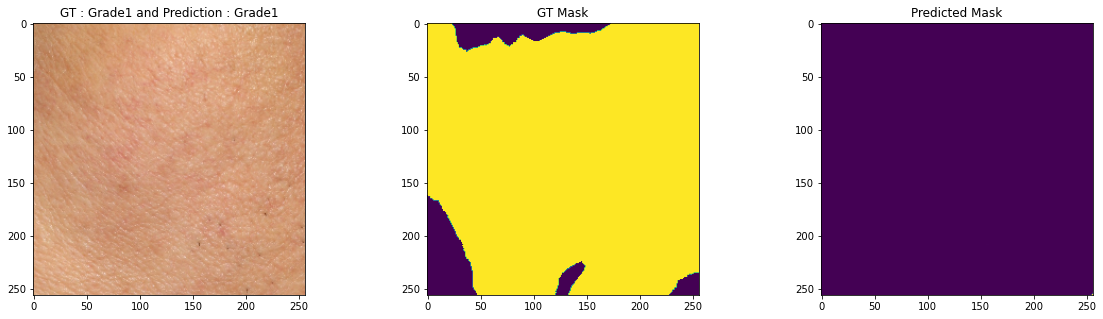

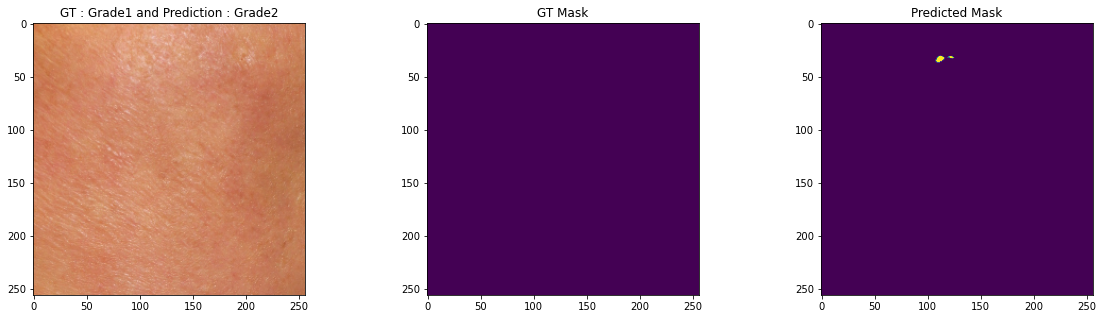

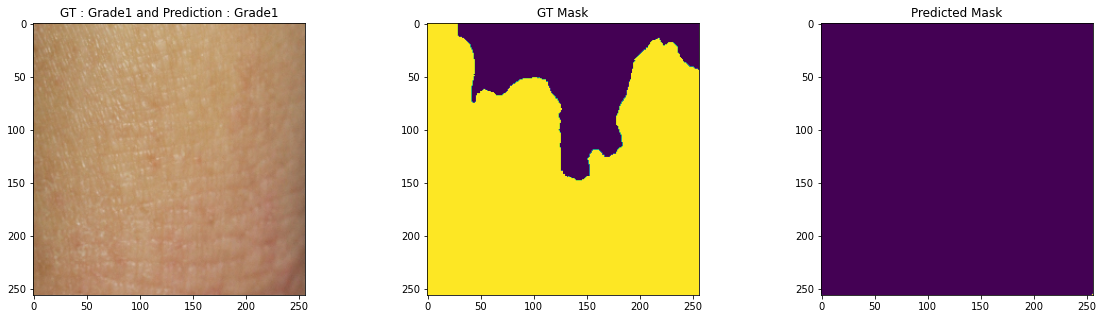

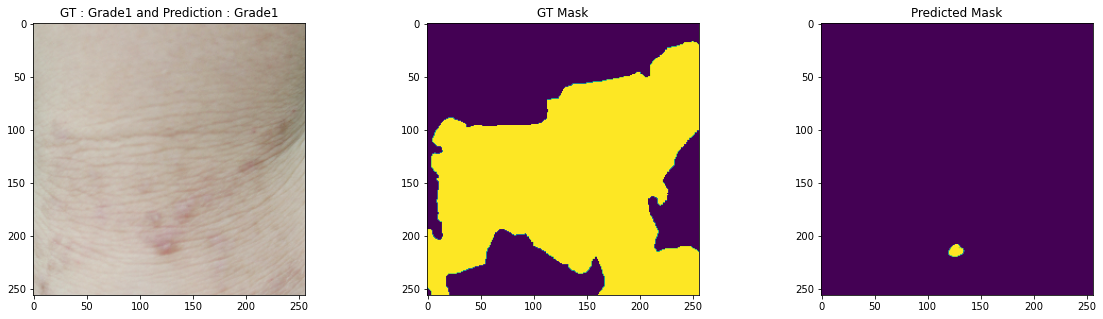

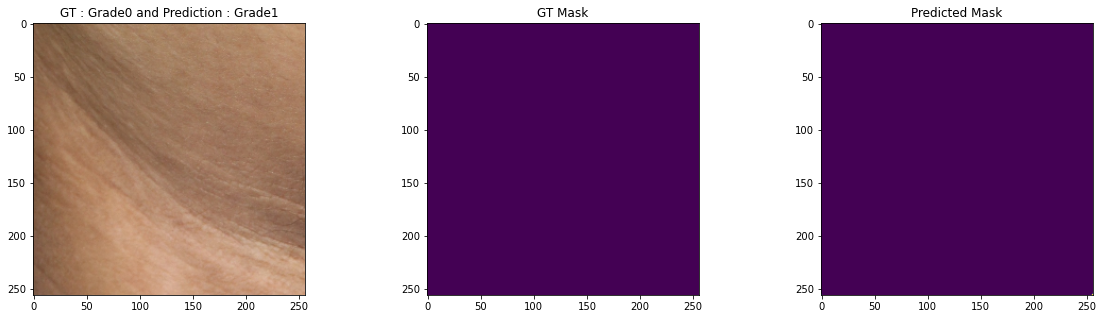

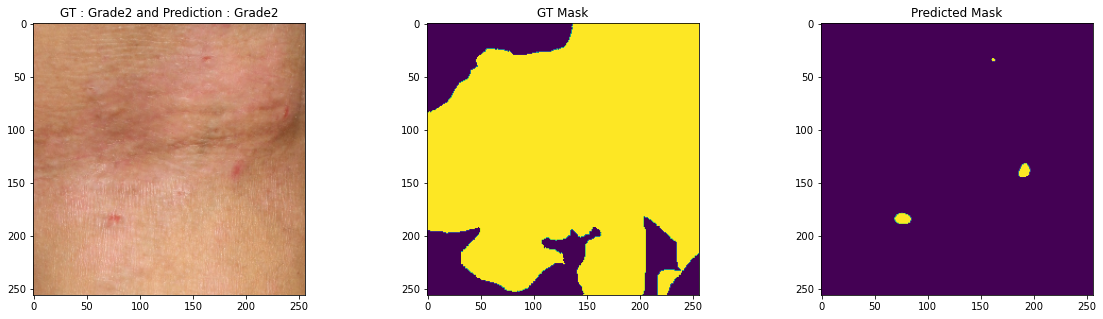

In [56]:
# loss, acc = model.evaluate(test_images, [test_masks, test_labels]], batch_size=16)
# loss, acc = model.evaluate(test_images, test_masks, batch_size=16)
cnt = 0 
for img, msk, lbl in zip(test_images, test_masks, test_labels): 
    
    pred = model.predict(img[tf.newaxis, ...])
    # print(pred[0].squeeze(0).shape)
    # print(pred.shape)
    # stack_img = np.stack([img, pred[0].squeeze(0)], axis=1)
    # print(grades_dict[lbl[0]])
    # print(grades_dict[np.argmax(pred[1])])
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1).set_title(f'GT : {grades_dict[lbl[0]]} and Prediction : {grades_dict[np.argmax(pred[1])]}')
    plt.imshow(img)
    
    plt.subplot(1, 3, 2).set_title('GT Mask')
    plt.imshow(msk)
    
    plt.subplot(1, 3, 3).set_title('Predicted Mask')
    plt.imshow(pred[0].squeeze(0))
    plt.show()
    
    # print(f'GT : {lbl} and Pred : {np.argmax(pred[1])}')
    
    # break
    if cnt > 10:
        break 
    cnt += 1
    

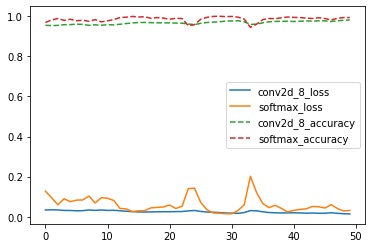

In [25]:
plt.plot(hist.history['conv2d_8_loss'], label='conv2d_8_loss')
plt.plot(hist.history['softmax_loss'], label='softmax_loss')
plt.plot(hist.history['conv2d_8_accuracy'], '--', label='conv2d_8_accuracy')
plt.plot(hist.history['softmax_accuracy'], '--', label='softmax_accuracy')
plt.legend()

In [16]:
hist = model.fit(train_images,
                # [train_images, train_images], 
                 [train_masks, train_labels],
                #  [train_masks],
                 batch_size=16,
                 epochs=20,
                 validation_split=0.3,
                 shuffle=True,
                #  callbacks=[reduce_lr]
                 )
# hist = model.fit(train_images, 
#                  train_masks,
#                  batch_size=16,
#                  epochs=100,
#                  validation_split=0.3,
#                 callbacks=[reduce_lr]
#                 )

Epoch 1/20


ValueError: in user code:

    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\workspace\child_segmentation\..\segmentation_models2\segmentation_models\metrics.py", line 62, in __call__  *
        **self.submodules
    File "c:\workspace\child_segmentation\..\segmentation_models2\segmentation_models\base\functional.py", line 93, in iou_score  *
        intersection = backend.sum(gt * pr, axis=axes)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\backend.py", line 2544, in sum
        return tf.reduce_sum(x, axis, keepdims)

    ValueError: Invalid reduction dimension 2 for input with 2 dimensions. for '{{node Sum_13}} = Sum[T=DT_FLOAT, Tidx=DT_INT32, keep_dims=false](mul_10, Sum_13/reduction_indices)' with input shapes: [?,4], [3] and with computed input tensors: input[1] = <0 1 2>.


In [14]:
pred = model.predict(test_images[0][tf.newaxis, ...])


array([[[[4.33218122e-01, 2.37608492e-01, 5.89547120e-03,
          1.51460627e-02, 3.41505148e-02],
         [6.67112470e-01, 1.48539141e-01, 7.23638979e-04,
          2.55491189e-03, 3.32363136e-03],
         [8.26270521e-01, 1.10180520e-01, 9.49147507e-04,
          3.73283005e-03, 4.09067981e-03],
         ...,
         [5.86475059e-02, 8.27313960e-01, 9.46455926e-04,
          3.03933583e-03, 2.51405104e-03],
         [5.82348965e-02, 8.19905162e-01, 7.78498012e-04,
          1.63470069e-03, 2.06445507e-03],
         [1.30340487e-01, 8.05666149e-01, 2.50228471e-03,
          2.23633517e-02, 2.24012025e-02]],

        [[5.96195877e-01, 1.53120309e-01, 6.42567000e-04,
          2.60584475e-03, 5.18427975e-03],
         [7.77717888e-01, 1.24973603e-01, 4.03104204e-05,
          1.29122185e-04, 1.08866290e-04],
         [8.99953425e-01, 6.63319826e-02, 9.84953367e-05,
          2.51989870e-04, 1.61515287e-04],
         ...,
         [2.78822426e-02, 9.27947342e-01, 3.44300825e-05,
   

In [18]:
# pred[3]
test_pred = pred.copy() 

In [23]:
# test_pred.squeeze()
test_pred = tf.squeeze(test_pred, axis=0)

In [26]:
test_pred[:, :, 1].shape

TensorShape([256, 256])

In [25]:
y_pred = model.predict(test_images[:10], batch_size=16)

In [35]:
def inf_add(y_unct):
    inference_num = 100
    imgs = []
    for kk in range(10):
        test_pred_imgs = y_unct[:, kk, :, :, :]
        
        heatmap_img = np.zeros((num_res, num_res), np.uint8)
        for jj in range(inference_num):
            pred_img = np.reshape(test_pred_imgs[jj], [num_res, num_res])        
            heatmap_img = np.add(heatmap_img, pred_img)
            
        new_heatmap = 255 - (heatmap_img / inference_num)
        imgs.append(new_heatmap)
        
    imgs = np.reshape(imgs, [-1, num_res, num_res, 1])
    return imgs

In [36]:
y_unct = np.stack([model(test_images[:10], training=True) for sample in range(100)])
y_unct = inf_add(y_unct)

In [37]:
y_unct.shape

(10, 256, 256, 1)

In [41]:
val = y_unct[0].mean()

In [39]:
test_masks[0].shape, y_pred[0].shape, y_unct[0].shape

((256, 256, 1), (256, 256, 1), (256, 256, 1))

In [44]:
calculate_pavpu(test_masks[0], y_pred[0], y_unct[0], accuracy_threshold=0.78, uncertainty_threshold=val)

AC: 0.0
AU: 0.0
IC: 59564.0
IU: 4951.0
A|C: 0.0
U|I: 0.07674184298225219
PAvPU: 0.07674184298225219


In [15]:
img_size = 256
inference_num = 100 ## inference 횟수
len_test_pred_imgs = y_samples[0].shape[0]

ni_list = []
for ni in range(1, len_test_pred_imgs * inference_num + 1):
    ni_list.append(inference_num * ni - 1)

# ni_list

In [16]:
# x_test_list
# OSError: [Errno 22] Invalid argument: 'C:/Users/user/Desktop/models/child_segmentation/heatmap/heatmap_C:/Users/user/Desktop/datasets/Atopy Segmentation\\Intersect_0.85\\Atopy_Segment_Test\\Grade0\\6621.jpg.png'

heatmap_dir = f'C:/Users/user/Desktop/models/child_segmentation/heatmap_{grade}/'
# heatmap_img_list = []    
# print(f'heatmap_img 1 : {heatmap_img.shape}')

for kk in range(len_test_pred_imgs):
    test_pred_imgs = y_samples[:, kk, :, :, :]
    
    heatmap_img = np.zeros((img_size, img_size), np.uint8)
    for jj in range(inference_num):
        pred_img = np.reshape(test_pred_imgs[jj], [img_size, img_size])        
        heatmap_img = np.add(heatmap_img, pred_img)
        
    new_heatmap = 255 - (heatmap_img / inference_num)
    # new_heatmap = 255 - new_heatmap
    
    plt.imsave(heatmap_dir + 'heatmap_' + x_test_list[kk].split('\\')[-1], new_heatmap, cmap='OrRd')

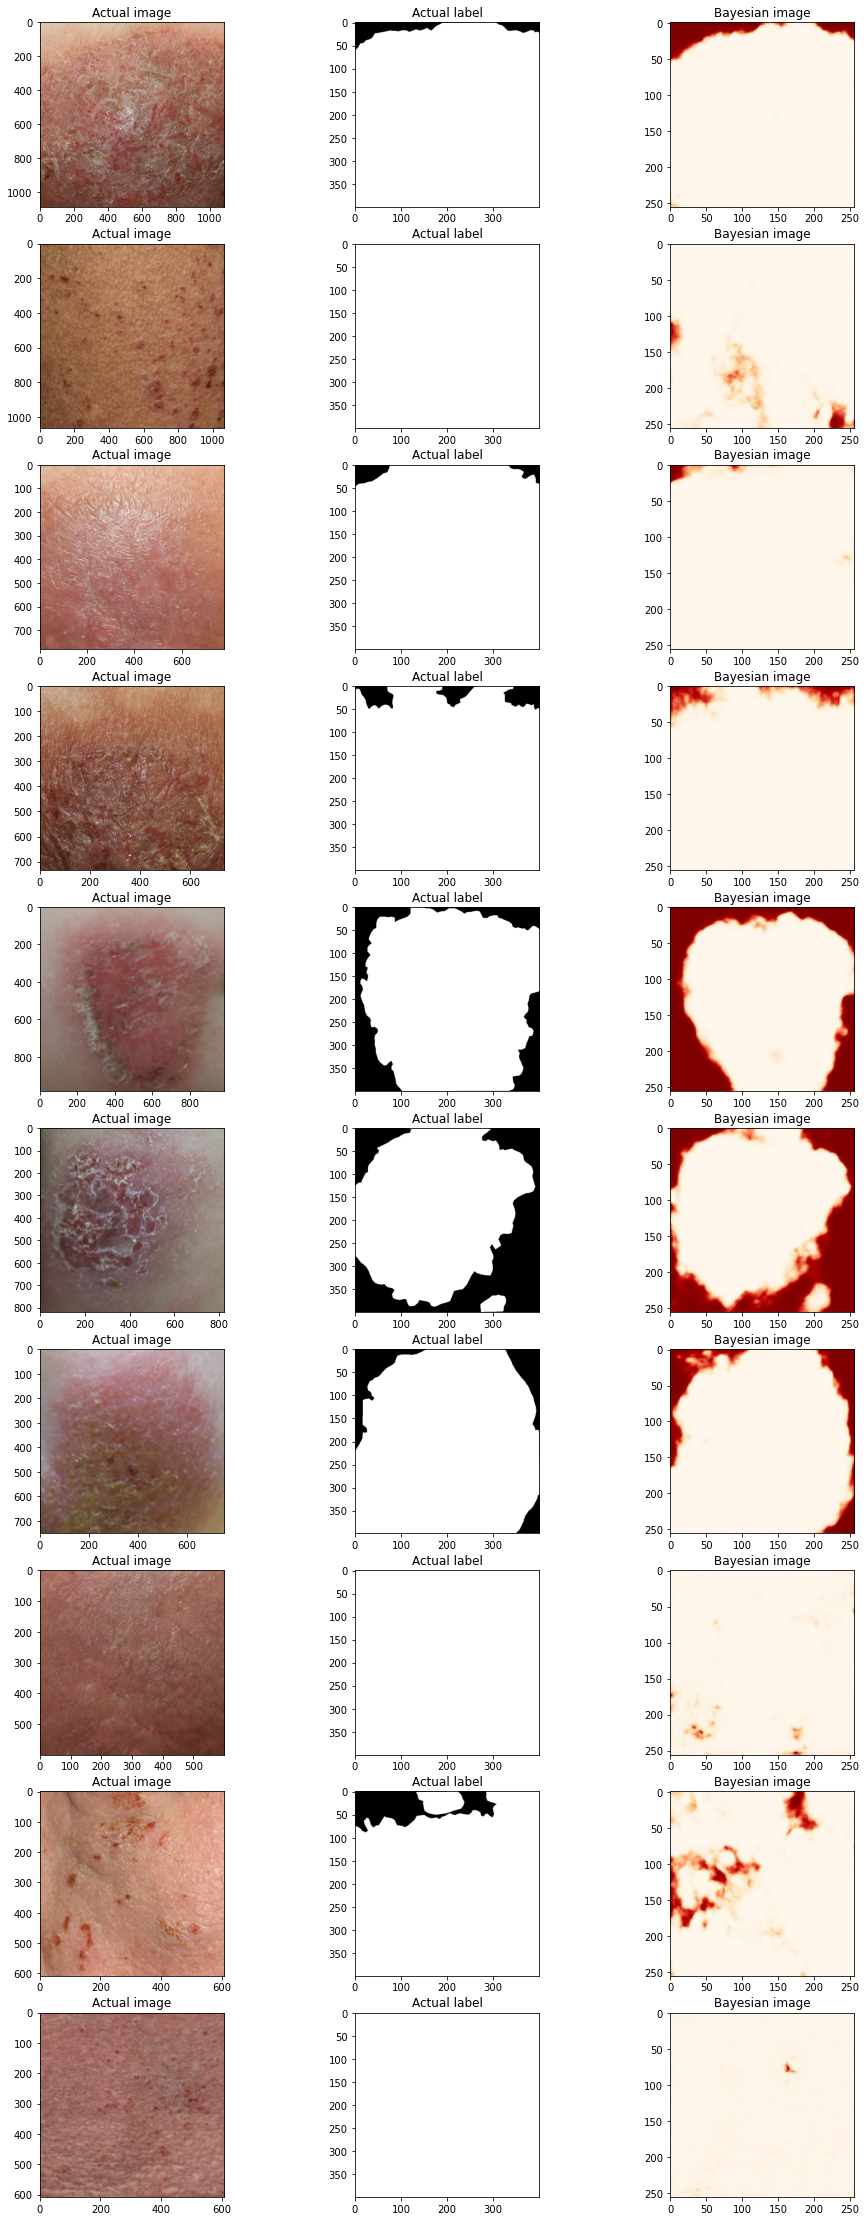

In [17]:
# test_images = 

heatmap_dir = f'C:/Users/user/Desktop/models/child_segmentation/heatmap_{grade}/'


num = 10
fig, ax = plt.subplots(figsize=(16,40), ncols=3, nrows=num)

for idx, test in enumerate(x_test_list[:num]):
    
    test_img = cv2.imread(test, cv2.COLOR_BGR2RGB)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_lbl = cv2.imread(test.replace('.jpg', '.png'))
    test_lbl = cv2.cvtColor(test_lbl, cv2.COLOR_BGR2RGB)
    
    heatmap_img = os.path.join(heatmap_dir, 'heatmap_' + test.split('\\')[-1]) 
    heatmap_img = cv2.imread(heatmap_img, cv2.COLOR_BGR2RGB) 
    heatmap_img = cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB)
    
    ax[idx, 0].imshow(test_img)
    ax[idx, 0].set_title('Actual image')
    
    ax[idx, 1].imshow(test_lbl)
    ax[idx, 1].set_title('Actual label')
    
    ax[idx, 2].imshow(heatmap_img)
    ax[idx, 2].set_title('Bayesian image')
    
    # ax[idx, 3].imshow(heatmap_img)
    # ax[idx, 3].set_title('Bayesian image')
    
    

In [22]:
# @ex.capture()
def calculate_pavpu(prediction, label, uncertainty,
                    accuracy_threshold=0.5, uncertainty_threshold=0.2, window_size=3):
    accurate_certain = 0.
    inaccurate_certain = 0.
    accurate_uncertain = 0.
    inaccurate_uncertain = 0.

    anchor = (0, 0)
    last_anchor = (prediction.shape[0] - window_size, prediction.shape[1] - window_size)

    while anchor != last_anchor:
        prediction_window = np.array([prediction[i][j]
                                      for i in range(anchor[0], anchor[0] + window_size)
                                      for j in range(anchor[1], anchor[1] + window_size)])

        label_window = np.array([label[i][j]
                                 for i in range(anchor[0], anchor[0] + window_size)
                                 for j in range(anchor[1], anchor[1] + window_size)])

        uncertainty_window = np.array([uncertainty[i][j]
                                       for i in range(anchor[0], anchor[0] + window_size)
                                       for j in range(anchor[1], anchor[1] + window_size)])

        accuracy = np.sum(prediction_window == label_window) / (window_size ** 2)
        avg_uncertainty = uncertainty_window.mean()

        accurate = True if accuracy >= accuracy_threshold else False
        uncertain = True if avg_uncertainty >= uncertainty_threshold else False

        if accurate:
            if uncertain:
                accurate_uncertain += 1
            else:
                accurate_certain += 1
        else:
            if uncertain:
                inaccurate_uncertain += 1
            else:
                inaccurate_certain += 1

        if anchor[1] < prediction.shape[1] - window_size:
            anchor = (anchor[0], anchor[1] + 1)
        else:
            anchor = (anchor[0] + 1, 0)

    print("AC: {}".format(accurate_certain))
    print("AU: {}".format(accurate_uncertain))
    print("IC: {}".format(inaccurate_certain))
    print("IU: {}".format(inaccurate_uncertain))

    a_given_c = accurate_certain / (accurate_certain + inaccurate_certain)
    u_given_i = inaccurate_uncertain / (inaccurate_certain + inaccurate_uncertain)

    print("A|C: {}".format(a_given_c))
    print("U|I: {}".format(u_given_i))

    pavpu = (accurate_certain + inaccurate_uncertain) / (accurate_certain + accurate_uncertain + inaccurate_certain + inaccurate_uncertain)

    print("PAvPU: {}".format(pavpu))

In [ ]:
# END

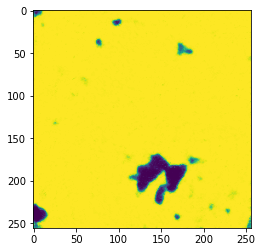

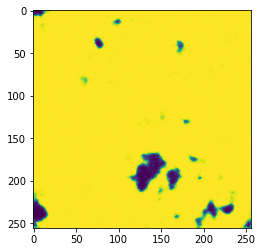

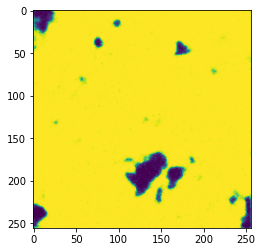

In [38]:
# plt.show(y_samples[0][0])
plt.imshow(y_samples[0][0])
plt.show() 

plt.imshow(y_samples[1][0])
plt.show() 

plt.imshow(y_samples[2][0])
plt.show()


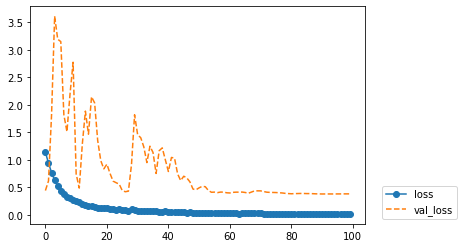

In [12]:
plt.plot(hist.history['loss'], marker='o', label='loss')
plt.plot(hist.history['val_loss'], '--', label='val_loss')
plt.legend(loc=(1.05, 0.02))
# plt.show()

plt.savefig('C:/Users/user/Desktop/models/child_segmentation/total_layer_loss.png')

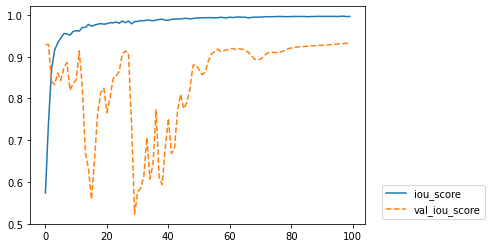

In [13]:
plt.plot(hist.history['iou_score'], label='iou_score')
plt.plot(hist.history['val_iou_score'], '--', label='val_iou_score')
plt.legend(loc=(1.05, 0.02))
# plt.show()

plt.savefig('C:/Users/user/Desktop/models/child_segmentation/total_layer_iou_score.png')
    

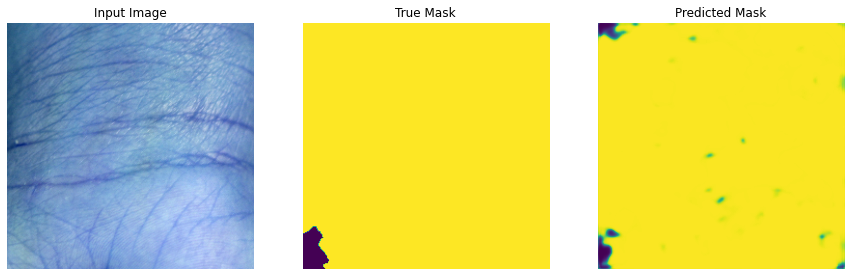

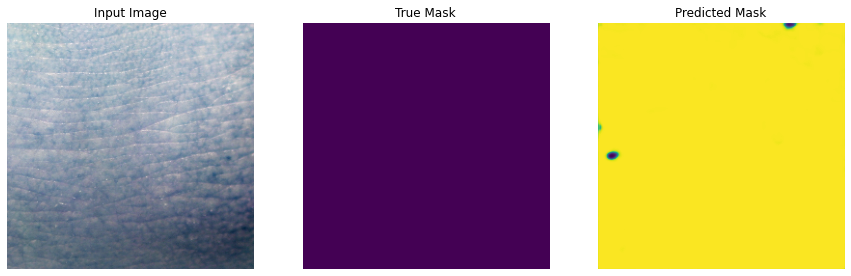

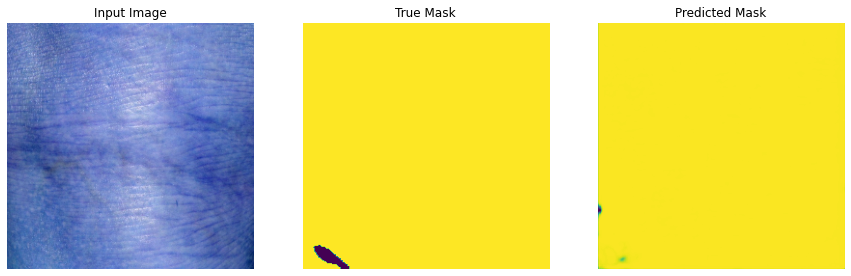

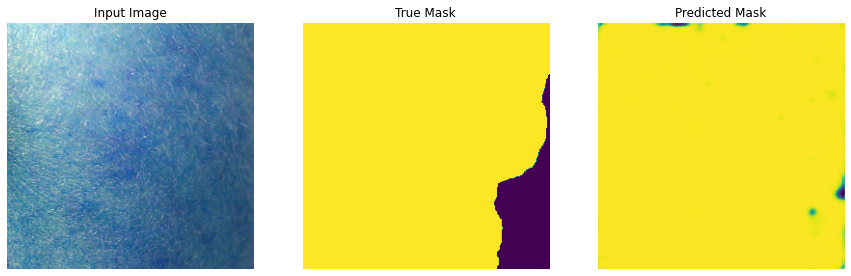

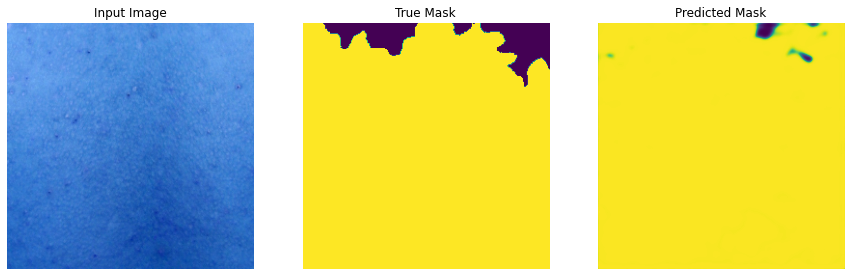

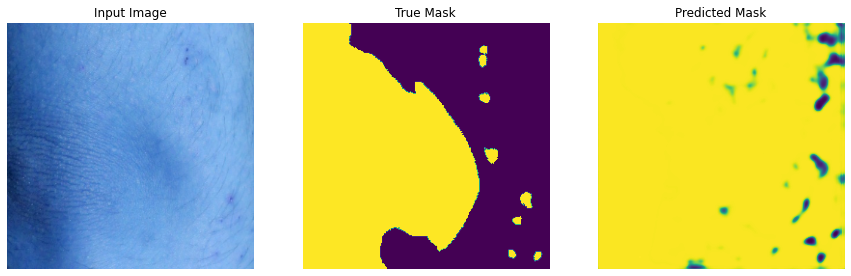

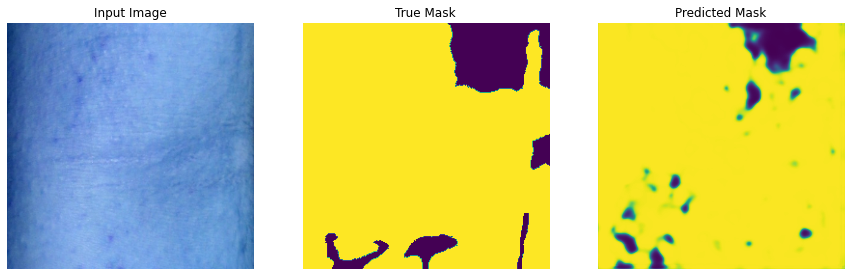

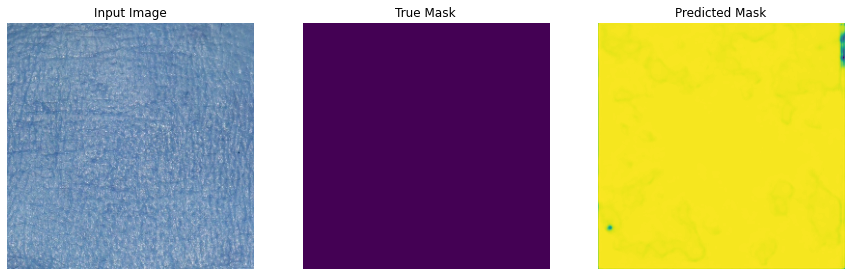

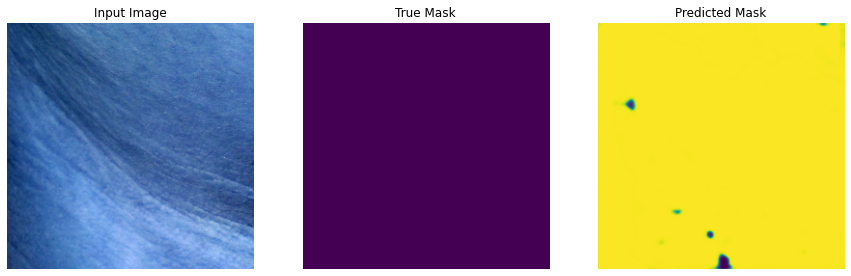

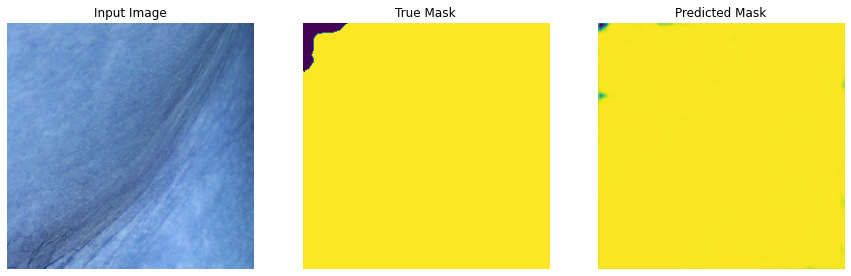

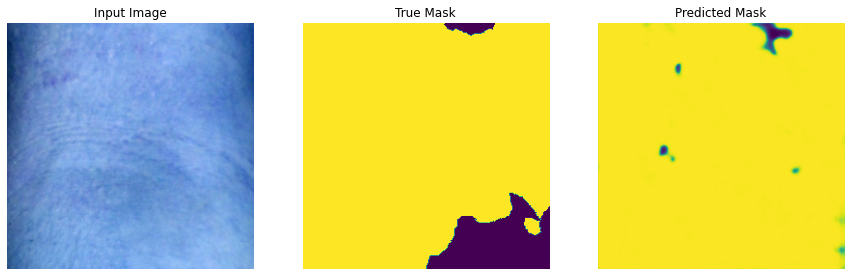

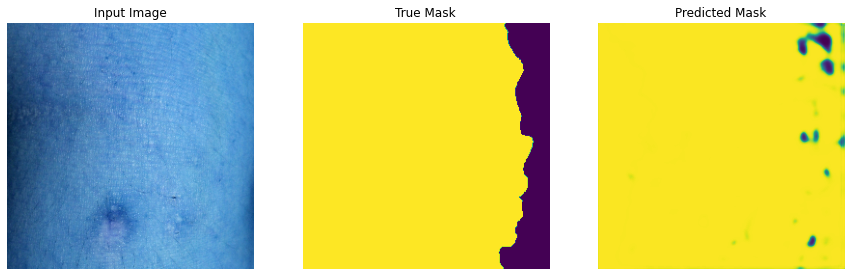

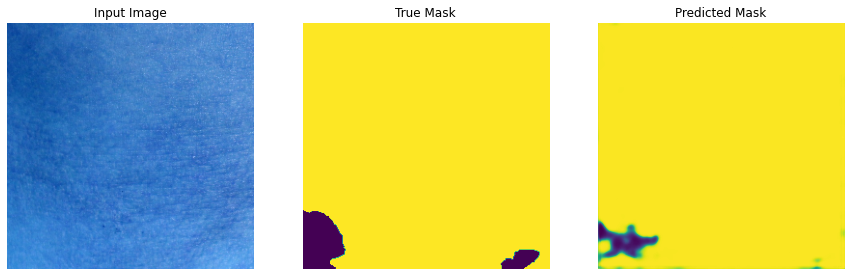

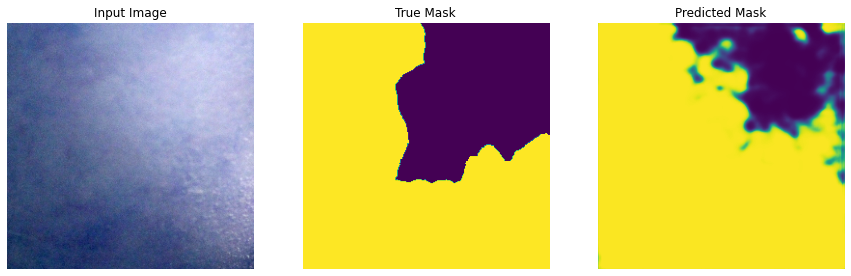

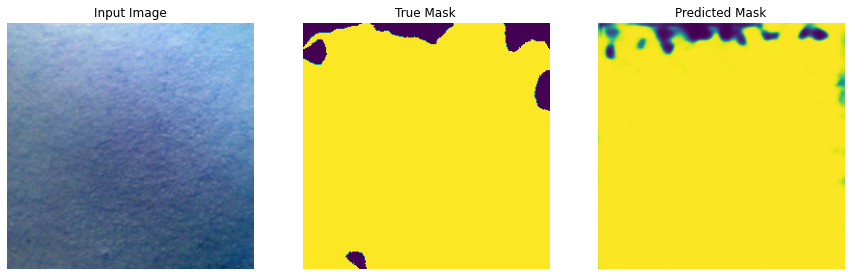

<Figure size 432x288 with 0 Axes>

In [14]:
for i in range(0, 15):
    sample_img = test_images[i]
    sample_lbl = test_labels[i]

    display([sample_img, sample_lbl, create_mask(model.predict(sample_img[tf.newaxis, ...]))])
            
    # plt.show()
    
plt.savefig('C:/Users/user/Desktop/models/child_segmentation/after_layer2_prediction.png')


In [14]:
model.save('C:/Users/user/Desktop/models/child_segmentation/total_layer.h5')

In [15]:
import pandas as pd
hist_df = pd.DataFrame(hist.history)
with open(f'C:/Users/user/Desktop/models/child_segmentation/total_layer.csv', mode='w') as f:
    hist_df.to_csv(f)

In [16]:
model.evaluate(test_images, test_labels)

1/1 [==============================] - 1s 1s/step - loss: 0.4549 - iou_score: 0.9172 - f1-score: 0.9568


[0.4548519551753998, 0.9172496199607849, 0.9568390250205994]

In [16]:
aug_size = 100 

randidx = np.random.randint(train_images.shape[0], size=aug_size)
# randidx

x_aug = train_images[randidx].copy() 
y_aug = train_labels[randidx].copy() 


In [17]:
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip


aug_train_images = [] 
aug_train_labels = [] 

for x, y in zip(train_images, train_labels):
    
    aug_train_images.append(x)
    aug_train_labels.append(y) 
    
    aug = RandomRotate90(p=1.0)
    augmented = aug(image=x, mask=y)
    aug_train_images.append(augmented['image'])
    aug_train_labels.append(augmented['mask'])

    aug = GridDistortion(p=1.0)
    augmented = aug(image=x, mask=y)
    aug_train_images.append(augmented['image'])
    aug_train_labels.append(augmented['mask'])

    aug = HorizontalFlip(p=1.0)
    augmented = aug(image=x, mask=y)
    aug_train_images.append(augmented['image'])
    aug_train_labels.append(augmented['mask'])

    aug = VerticalFlip(p=1.0)
    augmented = aug(image=x, mask=y)
    aug_train_images.append(augmented['image'])
    aug_train_labels.append(augmented['mask'])
    
    
aug_train_images = np.reshape(aug_train_images, [-1, N_RES, N_RES, 3]) 
aug_train_labels = np.reshape(aug_train_labels, [-1, N_RES, N_RES, 1]) 

aug_train_images.shape, aug_train_labels.shape

((460, 256, 256, 3), (460, 256, 256, 1))

In [18]:
# random mix up! 
randidx = np.random.randint(aug_train_images.shape[0], size=aug_train_images.shape[0])
# len(randidx)

mix_train_images = [] 
mix_train_labels = []
for idx in randidx:
    # print(idx)
    mix_train_images.append(aug_train_images[idx])
    mix_train_labels.append(aug_train_labels[idx])
    
    
mix_train_images = np.reshape(mix_train_images, [-1, N_RES, N_RES, 3]) 
mix_train_labels = np.reshape(mix_train_labels, [-1, N_RES, N_RES, 1]) 
    
    

In [25]:
hist = model1.fit(mix_train_images, 
                 mix_train_labels,
                 batch_size=16,
                 epochs=100,
                 validation_split=0.3,
                callbacks=[reduce_lr]
                )

Epoch 1/100


ValueError: in user code:

    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\compile_utils.py", line 184, in __call__
        self.build(y_pred)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\compile_utils.py", line 133, in build
        self._losses = tf.nest.map_structure(self._get_loss_object, self._losses)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\compile_utils.py", line 272, in _get_loss_object
        loss = losses_mod.get(loss)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\losses.py", line 2374, in get
        raise ValueError(

    ValueError: Could not interpret loss function identifier: <keras.optimizer_v2.adam.Adam object at 0x000001F435FEE610>


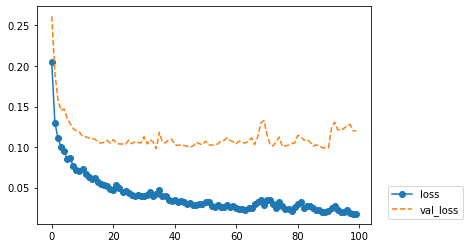

In [20]:
plt.plot(hist.history['loss'], marker='o', label='loss')
plt.plot(hist.history['val_loss'], '--', label='val_loss')
plt.legend(loc=(1.05, 0.02))
plt.show()

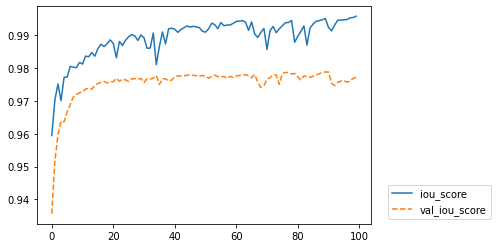

In [21]:
plt.plot(hist.history['iou_score'], label='iou_score')
plt.plot(hist.history['val_iou_score'], '--', label='val_iou_score')
plt.legend(loc=(1.05, 0.02))
plt.show()

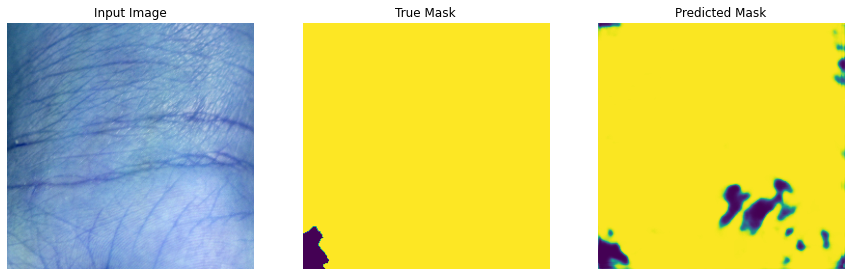

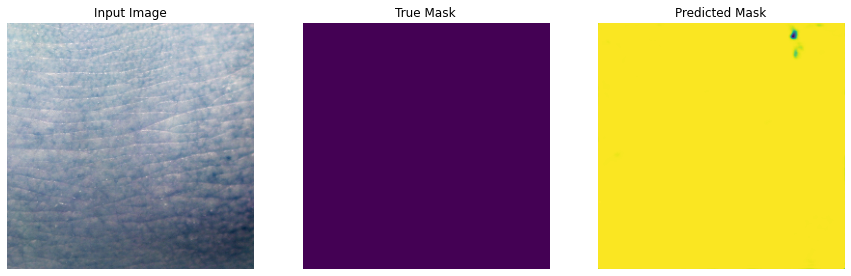

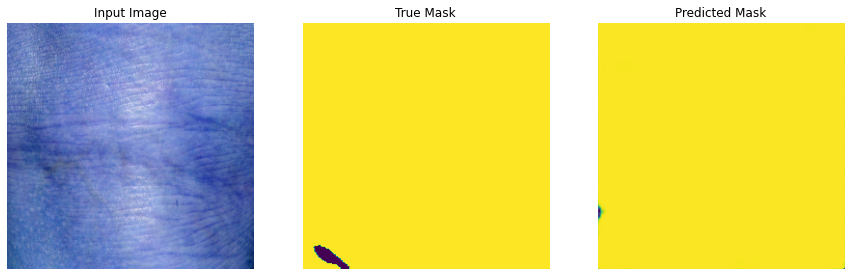

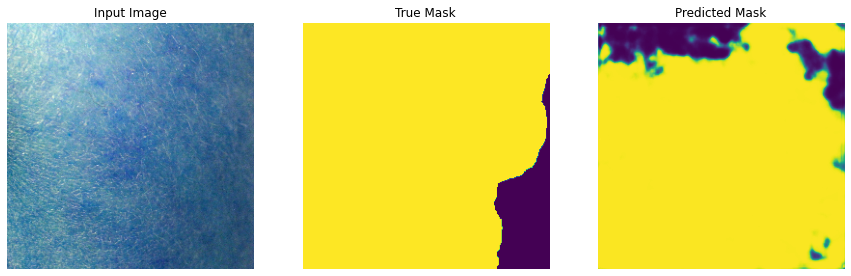

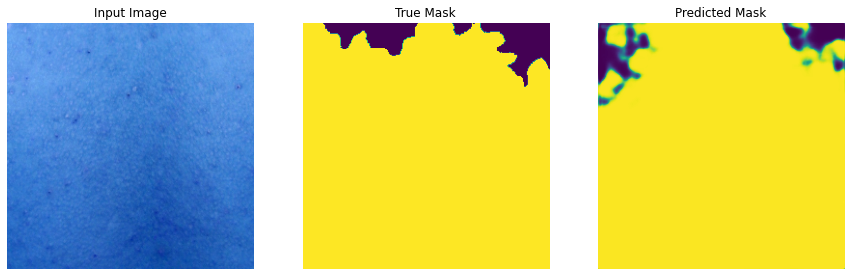

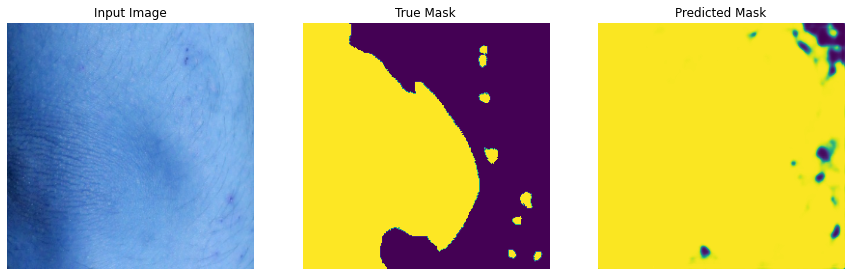

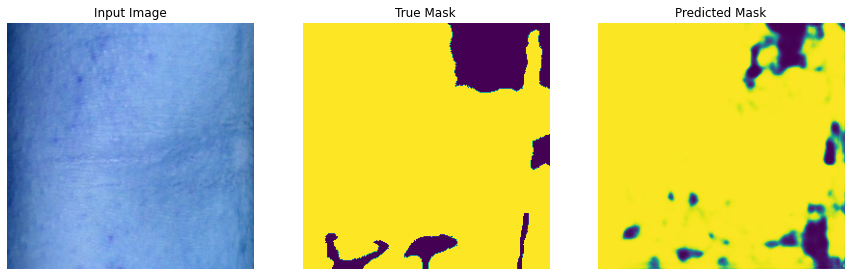

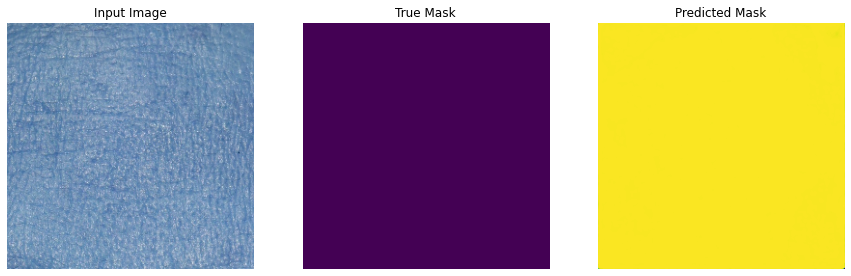

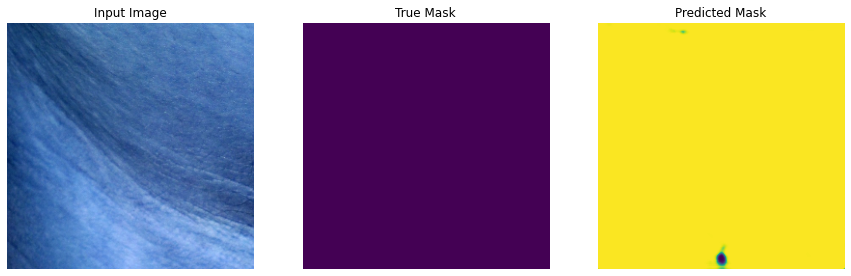

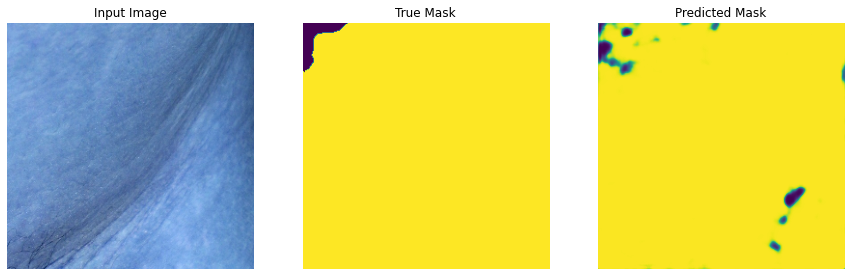

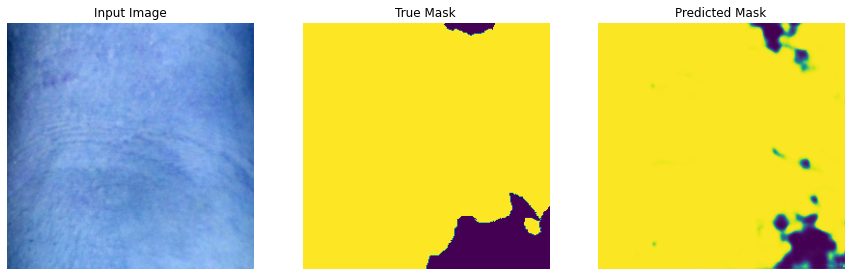

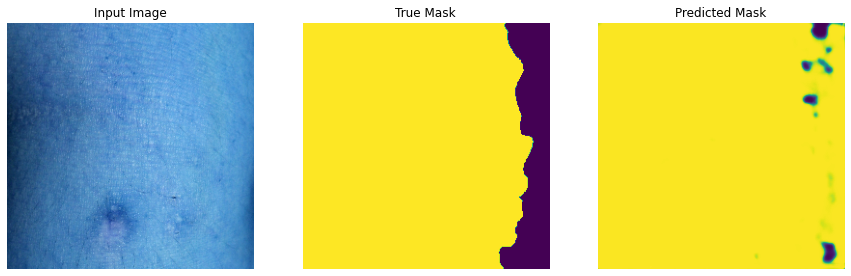

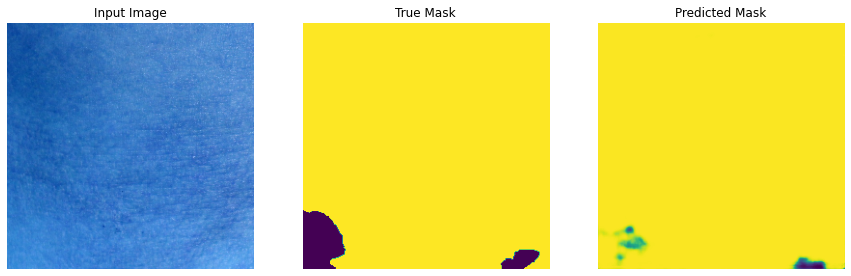

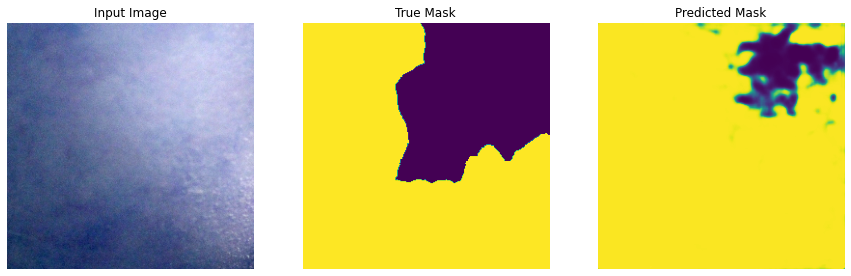

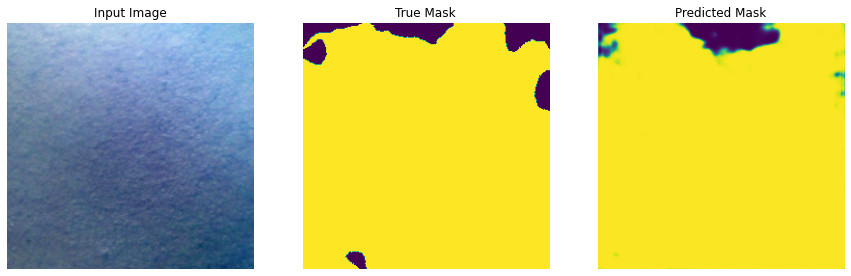

In [22]:
for i in range(0, 15):
    sample_img = test_images[i]
    sample_lbl = test_labels[i]

    display([sample_img, sample_lbl, create_mask(model1.predict(sample_img[tf.newaxis, ...]))])
            
    plt.show()

In [23]:
import time

model1.save(f'C:/Users/user/Desktop/models/child_segmentation/{time.strftime("%Y%m%d-%H%M%S")}_model.h5')